# Training the model

## Setup

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import shutil
drive.mount('/content/gdrive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (145 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [ ]:
# Read WSI
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# get the validate percentage of a image
def tissue_pixels_percentage(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percentage = len(tissue_pixels) / float(image.shape[0] * image.shape[0])
    return percentage

In [ ]:
def myImageShow(tumor, mask_tumor):
  plt.figure(figsize=(20,20), dpi=100)
  plt.subplot(131)
  plt.imshow(tumor)
  plt.subplot(132)
  plt.imshow(mask_tumor)
  plt.subplot(133)
  plt.imshow(tumor)
  plt.imshow(mask_tumor, cmap = "jet", alpha = 0.5)
  plt.show()

## Get the images from google drive and split them into training set and validaiton set

In [ ]:
root = '/content/level_3/'
train_dir = os.path.join(root, 'TrainSet')
val_dir = os.path.join(root, 'ValSet')
train_tumor_dir = os.path.join(train_dir, 'tumor')
train_non_tumor_dir = os.path.join(train_dir, 'non_tumor')
val_tumor_dir = os.path.join(val_dir, 'tumor')
val_non_tumor_dir = os.path.join(val_dir, 'non_tumor')
if not os.path.exists(root):
  os.mkdir(root)
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
if not os.path.exists(val_dir):
  os.mkdir(val_dir)
if not os.path.exists(train_tumor_dir):
  os.mkdir(train_tumor_dir)
if not os.path.exists(train_non_tumor_dir):
  os.mkdir(train_non_tumor_dir)
if not os.path.exists(val_tumor_dir):
  os.mkdir(val_tumor_dir)
if not os.path.exists(val_non_tumor_dir):
  os.mkdir(val_non_tumor_dir)

In [ ]:
original_tumor_dir = '/content/gdrive/MyDrive/level_3/tumor'
tumor_image_num = len(os.listdir(original_tumor_dir))
print(tumor_image_num)

480


In [ ]:
original_no_tumor_dir = '/content/gdrive/MyDrive/level_3/no_tumor'
no_tumor_image_num = len(os.listdir(original_no_tumor_dir))
print(no_tumor_image_num)

4015


In [ ]:
import math
train_image_num = math.floor(tumor_image_num * 0.8)
val_image_num = math.floor(tumor_image_num * 0.2)
print(train_image_num, val_image_num)

384 96


### Randomly Get Sample from the set
In the sample process, I try two ways to sample the first one is tumor: non_tumor = 1: 1 and the second one is tumor: non_tumor = 1: 2. From experiment, I I found that 1: 1 sample way have a better result. Therefore, sampling the tumor: non_tumor as 1:1 and split the sample into 2 parts: training set: validation set = 4: 1.

In [ ]:
tumor_sample = random.sample(range(1, tumor_image_num + 1), train_image_num + val_image_num)
no_tumor_sample = random.sample(range(1, no_tumor_image_num + 1), (train_image_num + val_image_num))
#no_tumor_sample = random.sample(range(1, no_tumor_image_num + 1), (train_image_num + val_image_num) * 2)

In [ ]:
print(len(tumor_sample))
print(len(no_tumor_sample))

480
480


In [ ]:
# Copy tumor images to train_tumor_dir
fnames = ['tumor_{}.png'.format(i) for i in tumor_sample[0: train_image_num]]
for fname in fnames:
    src = os.path.join(original_tumor_dir, fname)
    dst = os.path.join(train_tumor_dir, fname)
    shutil.copyfile(src, dst)

# Copy tumor images to val_tumor_dir
fnames = ['tumor_{}.png'.format(i) for i in tumor_sample[train_image_num::]]
for fname in fnames:
    src = os.path.join(original_tumor_dir, fname)
    dst = os.path.join(val_tumor_dir, fname)
    shutil.copyfile(src, dst)

print(len(os.listdir(val_tumor_dir))) 
print(len(os.listdir(train_tumor_dir)))

96
384


In [ ]:
# Copy non tumor images to train_tumor_dir

#fnames = ['no_tumor_{}.jpeg'.format(i) for i in no_tumor_sample[0: train_image_num * 2]]
fnames = ['no_tumor_{}.png'.format(i) for i in no_tumor_sample[0: train_image_num]]
for fname in fnames:
    src = os.path.join(original_no_tumor_dir, fname)
    dst = os.path.join(train_non_tumor_dir, fname)
    shutil.copyfile(src, dst)

# Copy non tumor images to val_tumor_dir
#fnames = ['no_tumor_{}.jpeg'.format(i) for i in no_tumor_sample[train_image_num * 2::]]
fnames = ['no_tumor_{}.png'.format(i) for i in no_tumor_sample[train_image_num::]]
for fname in fnames:
    src = os.path.join(original_no_tumor_dir, fname)
    dst = os.path.join(val_non_tumor_dir, fname)
    shutil.copyfile(src, dst)

print(len(os.listdir(val_non_tumor_dir)))
print(len(os.listdir(train_non_tumor_dir)))

96
384


## Trian the Model with Transfer Learning (Xception)


In [ ]:
base_model = tf.keras.applications.Xception(include_top = False, weights = "imagenet", input_shape = (299, 299, 3))
base_model.trainable = False
model=tf.keras.models.Sequential([   
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               26214528  
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 34        
Total params: 47,080,698
Trainable params: 26,219,218
Non-trainable params: 20,861,480
_________________________________

### Data Augmentation
The tumor image dataset is small, so using several ways to augment the dataset:
1. Rotation
2. Horizontal Flip and Vertical Flip
3. Random choose adjust brightness (max_delta = 64 / 255), contrast (upper = 0.75), hue (max_delta = 0.04) and saturation (upper = 0.25).

In [ ]:
def MyAugmentationFunction(image):
  choice = random.choice(["brightness", "contrast", "hue", "saturation"])
  if choice == "brightness":
    image = tf.image.random_brightness(image, max_delta = 64 / 255)
  if choice == "contrast":
    image = tf.image.random_contrast(image, lower = 0, upper = 0.75)
  if choice == "hue":
    image = tf.image.random_hue(image, max_delta = 0.04)
  if choice == "saturation":
    image = tf.image.random_saturation(image, lower = 0, upper = 0.25)
  return image

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                rotation_range = 90,
                                                                vertical_flip = True,
                                                                horizontal_flip = True,
                                                                preprocessing_function = MyAugmentationFunction)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode = 'categorical')

model.compile(optimizer ='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', tf.keras.metrics.AUC()])

history = model.fit(train_generator, verbose = 1, epochs = 20, validation_data = validation_generator)

Found 768 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 37s 2s/step - loss: 1.9952 - accuracy: 0.6094 - auc_5: 0.6196 - val_loss: 0.7308 - val_accuracy: 0.7031 - val_auc_5: 0.7949
Epoch 2/20
24/24 [==============================] - 37s 2s/step - loss: 0.5255 - accuracy: 0.7799 - auc_5: 0.8513 - val_loss: 0.4771 - val_accuracy: 0.8281 - val_auc_5: 0.8508
Epoch 3/20
24/24 [==============================] - 36s 2s/step - loss: 0.4811 - accuracy: 0.8099 - auc_5: 0.8773 - val_loss: 0.4728 - val_accuracy: 0.8125 - val_auc_5: 0.8778
Epoch 4/20
24/24 [==============================] - 37s 2s/step - loss: 0.4824 - accuracy: 0.8099 - auc_5: 0.8770 - val_loss: 0.4260 - val_accuracy: 0.8281 - val_auc_5: 0.8894
Epoch 5/20
24/24 [==============================] - 38s 2s/step - loss: 0.4063 - accuracy: 0.8398 - auc_5: 0.9019 - val_loss: 0.3553 - val_accuracy: 0.8385 - val_auc_5: 0.9221
Epoch 6/20
24/24 [====================

In [ ]:
train_generator.class_indices

{'non_tumor': 0, 'tumor': 1}

In [ ]:
# Save the model in google drive
model.save("/content/gdrive/MyDrive/MyModels/my_model_level_3_Xception_final_model_1.h5")

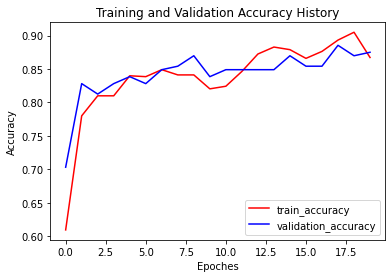

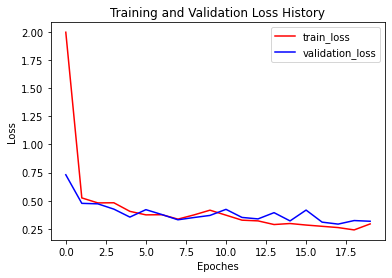

In [ ]:
# Accuracy History
plt.figure(1)
plt.title("Training and Validation Accuracy History")
plt.plot( history.history['accuracy'], color = "red", label = "train_accuracy")
plt.plot( history.history['val_accuracy'], color = "blue", label = "validation_accuracy")
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()

# Loss History
plt.figure(2)
plt.title("Training and Validation Loss History")
plt.plot(history.history['loss'], color = "red", label = "train_loss")
plt.plot(history.history['val_loss'], color = "blue", label = "validation_loss")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()

##Trian the Custom Model

In [ ]:
model=tf.keras.models.Sequential([  
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 146, 146, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 33, 33, 128)      

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                rotation_range = 90,
                                                                vertical_flip = True,
                                                                horizontal_flip = True,
                                                                preprocessing_function = MyAugmentationFunction)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size = (299, 299),
        batch_size = 32,
        class_mode = 'categorical')

model.compile(optimizer ='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', tf.keras.metrics.AUC()])

history = model.fit(train_generator, verbose = 1, epochs = 50, validation_data = validation_generator)

Found 768 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Epoch 1/50
24/24 [==============================] - 20s 853ms/step - loss: 0.6964 - accuracy: 0.4857 - auc_9: 0.4534 - val_loss: 0.6929 - val_accuracy: 0.5625 - val_auc_9: 0.5000
Epoch 2/50
24/24 [==============================] - 20s 837ms/step - loss: 0.6932 - accuracy: 0.5078 - auc_9: 0.4718 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_auc_9: 0.5684
Epoch 3/50
24/24 [==============================] - 20s 836ms/step - loss: 0.6860 - accuracy: 0.5885 - auc_9: 0.6190 - val_loss: 0.6155 - val_accuracy: 0.6979 - val_auc_9: 0.7580
Epoch 4/50
24/24 [==============================] - 20s 842ms/step - loss: 0.6662 - accuracy: 0.6146 - auc_9: 0.6537 - val_loss: 0.6664 - val_accuracy: 0.5625 - val_auc_9: 0.5969
Epoch 5/50
24/24 [==============================] - 20s 843ms/step - loss: 0.6170 - accuracy: 0.6615 - auc_9: 0.7132 - val_loss: 1.0194 - val_accuracy: 0.5000 - val_auc_9: 0.6050
Epoch 6/50
24/24 [=====

In [ ]:
# Save the model in google drive
model.save("/content/gdrive/MyDrive/MyModels/my_model_level_3_custom_final_model_1.h5")

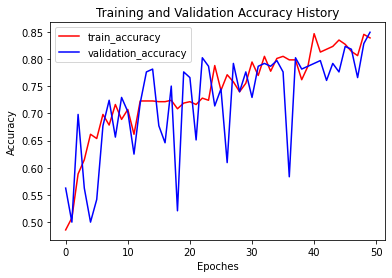

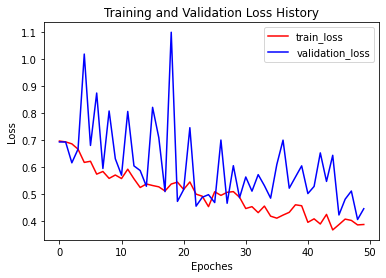

In [ ]:
# Accuracy History
plt.figure(1)
plt.title("Training and Validation Accuracy History")
plt.plot( history.history['accuracy'], color = "red", label = "train_accuracy")
plt.plot( history.history['val_accuracy'], color = "blue", label = "validation_accuracy")
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.legend()

# Loss History
plt.figure(2)
plt.title("Training and Validation Loss History")
plt.plot(history.history['loss'], color = "red", label = "train_loss")
plt.plot(history.history['val_loss'], color = "blue", label = "validation_loss")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()